In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm.auto import tqdm
import os
import sys
from joblib import Parallel, delayed
import torch
from IPython.display import clear_output

GPU_AVAILABLE = torch.cuda.is_available()
print(f"GPU Available: {GPU_AVAILABLE}\nCUDA Version: {torch.version.cuda if GPU_AVAILABLE else 'N/A'}")

### Dynamic Memory Allocation
if L_max<=128: use device local memory；
else: use global memory

=== 短链测试 (L=50) ===


/usr/local/lib/python3.10/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


result: [4.00000000e+04 1.20000000e+05 3.60000000e+05 1.00342800e+06
 2.84893200e+06 7.81012800e+06 2.17323000e+07 5.91086160e+07
 1.63045360e+08 4.41839104e+08 1.20809165e+09 3.25972890e+09
 8.86169600e+09 2.38785065e+10 6.44702781e+10 1.73594722e+11
 4.67455312e+11 1.25851822e+12 3.38276673e+12 9.10988044e+12
 2.44932191e+13 6.55000800e+13 1.75511842e+14 4.70643791e+14
 1.25987551e+15 3.36552859e+15 9.01050638e+15 2.39920223e+16
 6.42970305e+16 1.71599783e+17 4.55231899e+17 1.22032830e+18
 3.24290757e+18 8.63419213e+18 2.30624609e+19 6.13699804e+19
 1.63318642e+20 4.33527407e+20 1.15208222e+21 3.04167968e+21
 7.95915589e+21 2.10356383e+22 5.56539755e+22 1.49015095e+23
 3.89879322e+23 1.03985889e+24 2.75340281e+24 7.41718100e+24
 1.94626178e+25 5.10681877e+25]
μ = 2.652083, γ = 11.440209

=== 长链测试 (L=200) ===
result: [4.00000000e+04 1.20000000e+05 3.60000000e+05 9.98352000e+05
 2.83770000e+06 7.77049200e+06 2.16095040e+07 5.87894760e+07
 1.62313952e+08 4.40658368e+08 1.20596902e+09 3.

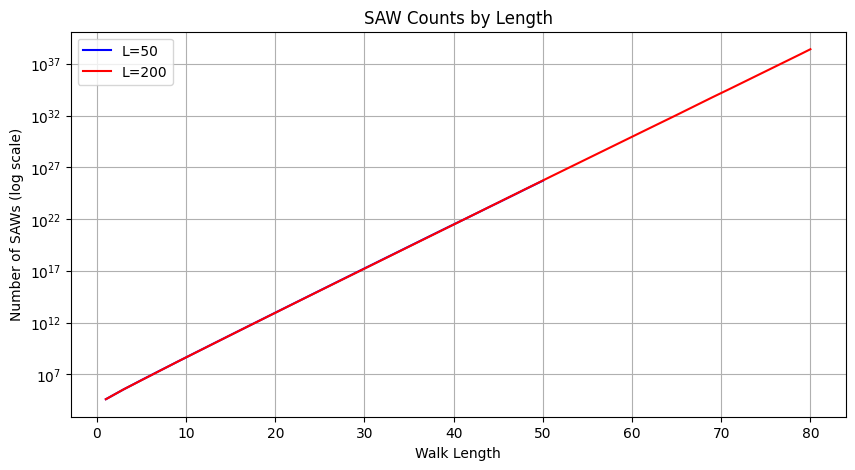

In [15]:
!pip install numba
import numpy as np
from numba import cuda, int32, float32
import math
import time

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True  # if set to False then global memory will be forced
LOCAL_MEM_MAX_LENGTH = 128  

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    # first check nearest 100 points
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1  # True
    
    # grid-optimised collision check
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1  # True
    else:
        # linearly check
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1  # True
    return 0  # False

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0

    # create new_pos array
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]

            if not collision_check(walk, walk_length, new_pos, 8):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)  # 0xFFFFFFFF = 4294967295

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= valid_count
        current_length += 1

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float32)
        self.global_walks = cuda.device_array(shape=(num_walks, max_length, 2), dtype=np.int32)
    
    def run(self):
        threads = 256  # optimise block size
        blocks = (self.num_walks + threads - 1) // threads
        
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        # transfer results to GPU
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)
        
        # run GPU kernel
        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks  
        )
        
        # get results from GPU
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]  

    def estimate_constants(self, fit_start=30):
        lengths = np.arange(fit_start, self.max_length+1)
        log_cn = np.log(self.results[fit_start:self.max_length+1] + 1e-10)  # avoid log(0)
        coeffs = np.polyfit(lengths, log_cn, 1)
        return np.exp(coeffs[0]), coeffs[1]+1

# ================== Test Cases ==================
if __name__ == "__main__":
    print("===  L=50 ===")
    sim1 = AdaptivePERM(max_length=50, num_walks=10000)
    results1 = sim1.run()
    mu1, gamma1 = sim1.estimate_constants()
    print(f"μ = {mu1:.6f}, γ = {gamma1:.6f}")
    
    print("\n=== L=200 ===")
    sim2 = AdaptivePERM(max_length=200, num_walks=10000)
    start = time.time()
    results2 = sim2.run()
    gpu_time = time.time() - start
    mu2, gamma2 = sim2.estimate_constants()
    print(f"μ = {mu2:.6f}, γ = {gamma2:.6f}")
    print(f"GPU Time: {gpu_time:.3f}s")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(1, sim1.max_length+1), results1, 'b-', label='L=50')
    plt.plot(np.arange(1, sim2.max_length+1), results2, 'r-', label='L=200')
    plt.xlabel('Walk Length')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.legend()
    plt.grid(True)
    plt.show()

### Post-simulation Analysis
the method works for 
inf is observed when L is over 100, due to the extreme large sum of samples' weights.

### Fix
we first try to discard the samples with extreme weights.

=== Short Chain Test (L=50) ===
result: [4.00000000e+05 1.20000000e+06 3.60000000e+06 1.00005120e+07
 2.83940640e+07 7.79926320e+07 2.17323972e+08 5.91895188e+08
 1.62763733e+09 4.41467528e+09 1.20427174e+10 3.24886976e+10
 8.82421695e+10 2.37888187e+11 6.43065448e+11 1.72970884e+12
 4.65798878e+12 1.24990491e+13 3.35625547e+13 8.98570687e+13
 2.41109423e+14 6.45391567e+14 1.72767030e+15 4.61451514e+15
 1.23664946e+16 3.30709374e+16 8.82927105e+16 2.35865598e+17
 6.30034301e+17 1.67937863e+18 4.48932538e+18 1.19640205e+19
 3.18253412e+19 8.49564422e+19 2.26983055e+20 6.05101526e+20
 1.61289214e+21 4.30372571e+21 1.14517289e+22 3.05388250e+22
 8.11834536e+22 2.15950148e+23 5.74375133e+23 1.52514423e+24
 4.06432855e+24 1.07711496e+25 2.85516019e+25 7.60197137e+25
 2.02213726e+26 5.37522627e+26]
μ = 2.643799, γ = 1.279471

=== Long Chain Test (L=200) ===
result: [4.00000000e+05 1.20000000e+06 3.60000000e+06 9.99439200e+06
 2.83920120e+07 7.79558040e+07 2.16941976e+08 5.90621220e+08
 1.623

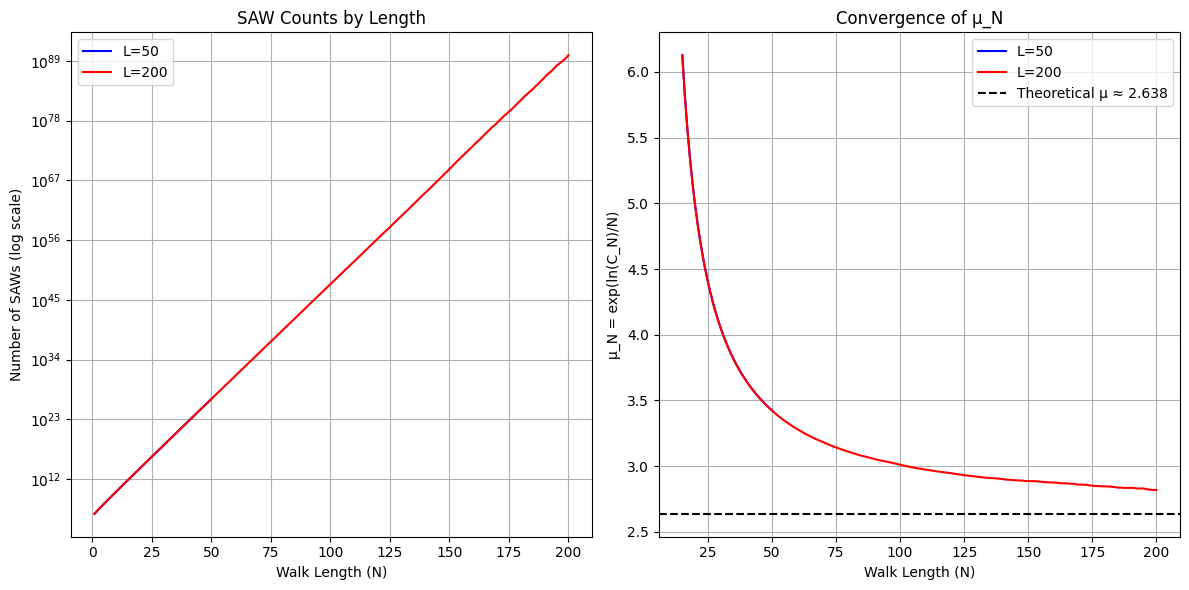

In [6]:
!pip install numba scipy
import numpy as np
from numba import cuda, int32, float64
import math
import time
from scipy.optimize import curve_fit

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 8):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= valid_count
        current_length += 1

        if weight > 1e100 or weight < 1e-100:
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float64)
        self.global_walks = cuda.device_array(shape=(num_walks, max_length, 2), dtype=np.int32)
    
    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)
        
        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks  
        )
        
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit based on equation (2.13)."""
        # Prepare data for fitting
        lengths = np.arange(fit_start, self.max_length + 1)
        c_N = self.results[fit_start:self.max_length + 1]
        # Compute response: ln(C_N)/N, handle zeros/infs
        response = [np.log(max(c, 1e-10)) / N for c, N in zip(c_N, lengths)]
        
        # Define fitting function: ln(C_N)/N = log_mu + ((y-1) * ln(N))/N + A/N
        def fitting_func(N, log_mu, A, y):
            return log_mu + ((y-1) * np.log(N)) / N + A / N
        
        # Initial guess: log_mu ~ ln(2.638), A ~ 1.0, y ~ 1.344
        p0 = [np.log(2.638), 1.0, 1.344]
        
        try:
            # Perform curve fitting
            popt, pcov = curve_fit(fitting_func, lengths, response, p0=p0)
            log_mu_est, A_est, y_est = popt
            
            # Calculate estimated mu
            mu_est = np.exp(log_mu_est)
            
            # Calculate mu_N = exp(ln(C_N)/N) for analysis
            mu_N = [np.exp(np.log(max(c, 1e-10)) / N) for c, N in zip(c_N, lengths)]
            
            return mu_est, y_est, mu_N
        except RuntimeError:
            print("Curve fitting failed, returning NaN values.")
            return np.nan, np.nan, []

# ================== Test Example ==================
if __name__ == "__main__":
    print("=== Short Chain Test (L=50) ===")
    sim1 = AdaptivePERM(max_length=50, num_walks=100000)
    results1 = sim1.run()
    mu1, gamma1, mu_N1 = sim1.estimate_constants()
    print(f"μ = {mu1:.6f}, γ = {gamma1:.6f}")
    
    print("\n=== Long Chain Test (L=200) ===")
    sim2 = AdaptivePERM(max_length=200, num_walks=100000)
    start = time.time()
    results2 = sim2.run()
    gpu_time = time.time() - start
    mu2, gamma2, mu_N2 = sim2.estimate_constants()
    print(f"μ = {mu2:.6f}, γ = {gamma2:.6f}")
    print(f"GPU Time: {gpu_time:.3f}s")

    # Visualize results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    
    # Plot C_N
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, sim1.max_length+1), results1, 'b-', label='L=50')
    plt.plot(np.arange(1, sim2.max_length+1), results2, 'r-', label='L=200')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.legend()
    plt.grid(True)
    
    # Plot mu_N
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(15, sim1.max_length+1), mu_N1, 'b-', label='L=50')
    plt.plot(np.arange(15, sim2.max_length+1), mu_N2, 'r-', label='L=200')
    plt.axhline(y=2.638, color='k', linestyle='--', label='Theoretical μ ≈ 2.638')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('μ_N = exp(ln(C_N)/N)')
    plt.title('Convergence of μ_N')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Larger L test
We then try even larger L, e.g., when L is 1000

=== Short Chain Test (L=50) ===
result: [4.00000000e+05 1.20000000e+06 3.60000000e+06 1.00009440e+07
 2.84165280e+07 7.79655240e+07 2.17051488e+08 5.91425388e+08
 1.62799211e+09 4.41202172e+09 1.20417600e+10 3.25050097e+10
 8.80432108e+10 2.37464142e+11 6.41462867e+11 1.72389863e+12
 4.64488636e+12 1.24628907e+13 3.34642911e+13 8.97737875e+13
 2.40790273e+14 6.44677518e+14 1.73032676e+15 4.62574067e+15
 1.23375616e+16 3.29723737e+16 8.81615020e+16 2.35156972e+17
 6.27425722e+17 1.67369972e+18 4.45891043e+18 1.18797662e+19
 3.17035101e+19 8.44972633e+19 2.25317602e+20 6.00520097e+20
 1.60045768e+21 4.26769822e+21 1.13684582e+22 3.03364488e+22
 8.08957106e+22 2.14878041e+23 5.72642684e+23 1.53126873e+24
 4.07434163e+24 1.08596993e+25 2.87555293e+25 7.62411347e+25
 2.01938811e+26 5.36159846e+26]
μ = 2.644611, γ = 1.270827

=== Long Chain Test (L=1000) ===
result: [4.00000000e+005 1.20000000e+006 3.60000000e+006 1.00098720e+007
 2.84156640e+007 7.81359480e+007 2.17500228e+008 5.92776468e+0

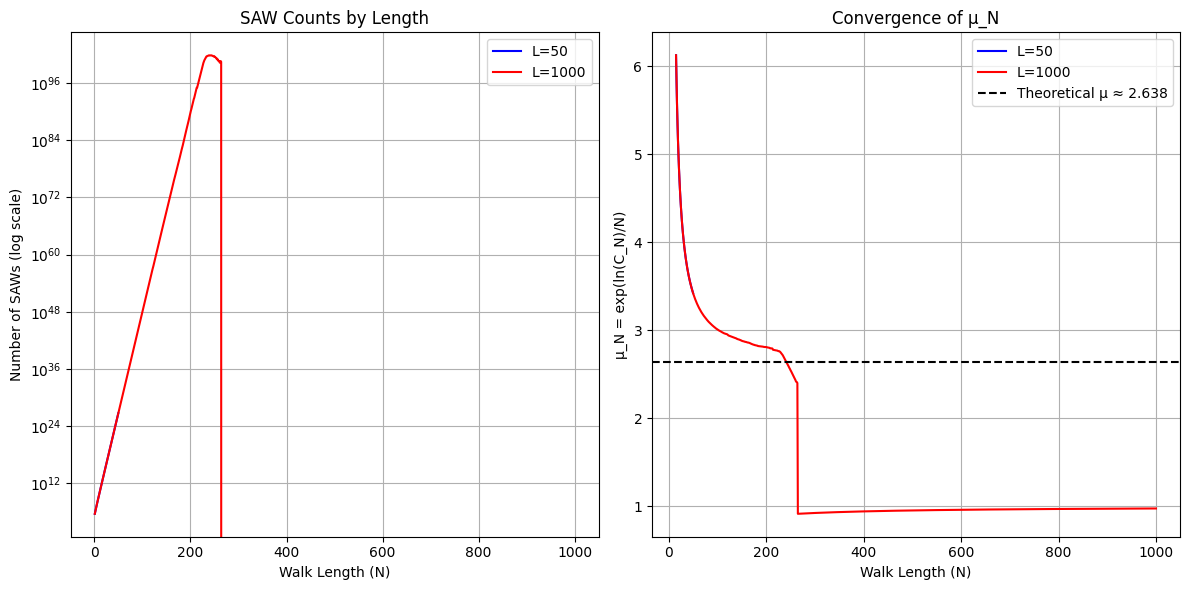

In [2]:
!pip install numba scipy
import numpy as np
from numba import cuda, int32, float64
import math
import time
from scipy.optimize import curve_fit

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array(shape=(4,2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 8):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= valid_count
        current_length += 1

        if weight > 1e100 or weight < 1e-100:
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length+1, dtype=np.float64)
        self.global_walks = cuda.device_array(shape=(num_walks, max_length, 2), dtype=np.int32)
    
    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)
        
        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks  
        )
        
        self.results = d_results.copy_to_host()
        print(f"result: {self.results[1:self.max_length+1]}")
        return self.results[1:self.max_length+1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit based on equation (2.13)."""
        # Prepare data for fitting
        lengths = np.arange(fit_start, self.max_length + 1)
        c_N = self.results[fit_start:self.max_length + 1]
        # Compute response: ln(C_N)/N, handle zeros/infs
        response = [np.log(max(c, 1e-10)) / N for c, N in zip(c_N, lengths)]
        
        # Define fitting function: ln(C_N)/N = log_mu + ((y-1) * ln(N))/N + A/N
        def fitting_func(N, log_mu, A, y):
            return log_mu + ((y-1) * np.log(N)) / N + A / N
        
        # Initial guess: log_mu ~ ln(2.638), A ~ 1.0, y ~ 1.344
        p0 = [np.log(2.638), 1.0, 1.344]
        
        try:
            # Perform curve fitting
            popt, pcov = curve_fit(fitting_func, lengths, response, p0=p0)
            log_mu_est, A_est, y_est = popt
            
            # Calculate estimated mu
            mu_est = np.exp(log_mu_est)
            
            # Calculate mu_N = exp(ln(C_N)/N) for analysis
            mu_N = [np.exp(np.log(max(c, 1e-10)) / N) for c, N in zip(c_N, lengths)]
            
            return mu_est, y_est, mu_N
        except RuntimeError:
            print("Curve fitting failed, returning NaN values.")
            return np.nan, np.nan, []

# ================== Test Example ==================
if __name__ == "__main__":
    print("=== Short Chain Test (L=50) ===")
    sim1 = AdaptivePERM(max_length=50, num_walks=100000)
    results1 = sim1.run()
    mu1, gamma1, mu_N1 = sim1.estimate_constants()
    print(f"μ = {mu1:.6f}, γ = {gamma1:.6f}")
    
    print("\n=== Long Chain Test (L=1000) ===")
    sim2 = AdaptivePERM(max_length=1000, num_walks=100000)
    start = time.time()
    results2 = sim2.run()
    gpu_time = time.time() - start
    mu2, gamma2, mu_N2 = sim2.estimate_constants()
    print(f"μ = {mu2:.6f}, γ = {gamma2:.6f}")
    print(f"GPU Time: {gpu_time:.3f}s")

    # Visualize results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    
    # Plot C_N
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, sim1.max_length+1), results1, 'b-', label='L=50')
    plt.plot(np.arange(1, sim2.max_length+1), results2, 'r-', label='L=1000')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('Number of SAWs (log scale)')
    plt.yscale('log')
    plt.title('SAW Counts by Length')
    plt.legend()
    plt.grid(True)
    
    # Plot mu_N
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(15, sim1.max_length+1), mu_N1, 'b-', label='L=50')
    plt.plot(np.arange(15, sim2.max_length+1), mu_N2, 'r-', label='L=1000')
    plt.axhline(y=2.638, color='k', linestyle='--', label='Theoretical μ ≈ 2.638')
    plt.xlabel('Walk Length (N)')
    plt.ylabel('μ_N = exp(ln(C_N)/N)')
    plt.title('Convergence of μ_N')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Post-simulation Analysis
#### we can see this approach fails to work for higher L.
e.g, when L = 300, $weight \approx (2.638) ^ {300} \approx 10^{120}$, which is large than the threshold.

#### we use normalisation method instead to ensure its compatibility with high L value.
weight = $\prod_{i=0}^{L-1}(atmosphere(i) / 2.638)$ 

### Test 1 after using normalisation


=== Test Case: L=100 ===
Results: [15163002.27491137 17243747.8457375  19610024.09135944 20649129.37890547
 22230288.00374599 23144865.61469868 24428233.98108148 25223709.73720251
 26289950.13180535 27017877.29627281 27934876.47107905 28604006.85541684
 29417968.00395049 30041719.52778336 30771585.82596196 31348246.57787857
 32018208.16527706 32563607.52338021 33186665.42146821 33700040.56111266
 34277556.49838359 34762286.69746682 35299675.47509454 35762304.94016686
 36279807.70440078 36721372.67743523 37210533.60668221 37631870.52695353
 38100363.58435012 38510467.1368667  38951216.99870318 39342115.28980345
 39769886.07764816 40149751.38244987 40571136.95784815 40934796.09088157
 41336807.03645839 41697376.54977002 42083961.07038146 42424175.13395341
 42807956.55841324 43150697.37688684 43500051.66713176 43836076.64015476
 44183924.56039851 44479331.16173931 44795371.1067139  45095494.29304379
 45428767.9982916  45725696.32655679 46023195.44245501 46304110.24911318
 46613480.444988

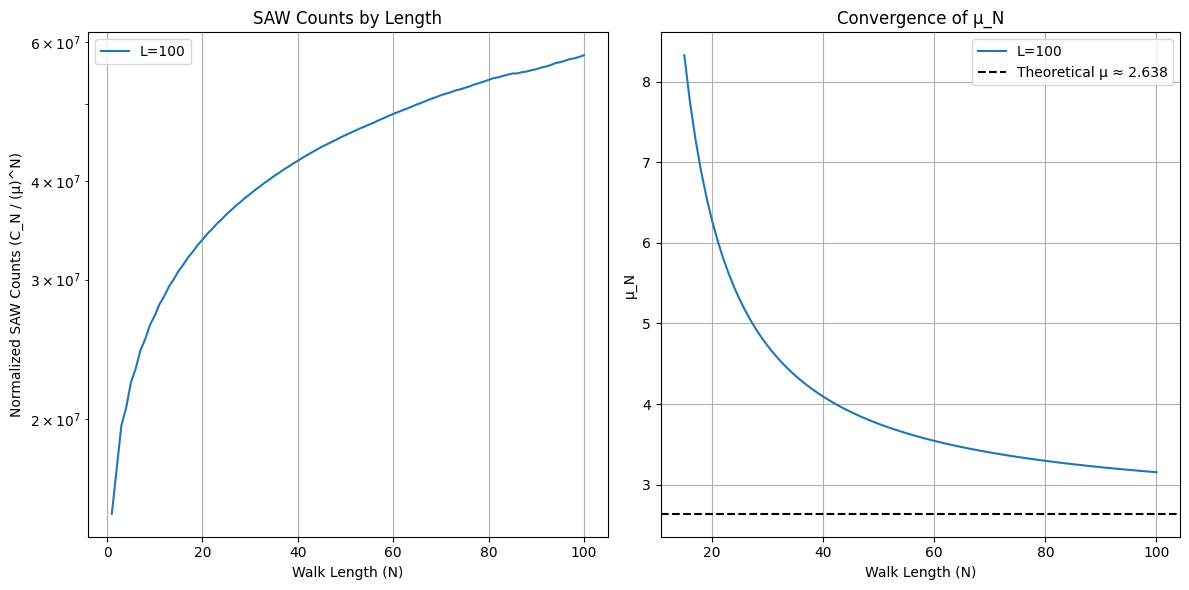

In [4]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length + 1, dtype=np.float64)
        self.global_walks = cuda.device_array((num_walks, max_length, 2), dtype=np.int32)

    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)

        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks
        )

        self.results = d_results.copy_to_host()
        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 100, "num_walks": 10000000, "label": "L=100"},
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], num_walks=case["num_walks"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.16f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        plt.plot(np.arange(min(15, max_length // 2), max_length + 1), mu_N, label=label)
    plt.axhline(y=2.638, color="k", linestyle="--", label="Theoretical μ ≈ 2.638")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Test 2


=== Test Case: L=50 ===
Results: [1516300.22747394 1724374.7848408  1961002.40877446 2064841.1288282
 2223051.71026032 2314962.22155769 2443931.53929857 2523681.23090923
 2630931.06880768 2704257.83352117 2795823.93061004 2863058.36771458
 2944566.38372226 3006165.79412216 3079562.63409407 3137739.76801637
 3205571.22872267 3260231.16020577 3323132.87943508 3374808.98732671
 3431119.24508043 3482098.73396332 3536438.67500559 3582597.1977708
 3633053.95641294 3677099.80229139 3723707.11398246 3766310.60917457
 3814205.34955234 3857294.36933117 3902060.73195865 3942173.71571122
 3987468.726976   4025369.59725447 4067164.06951653 4106577.68396605
 4146321.94558261 4184467.65750982 4223275.18298221 4261098.47349324
 4299740.3662009  4333686.25018584 4364589.05244045 4398064.72188608
 4435321.07416094 4466953.32370208 4498022.63953508 4527146.75459544
 4560825.44183171 4591123.80775344]
μ = 2.640241, γ = 1.309404
GPU Time: 0.863s

=== Test Case: L=500 ===
Results: [1.51630023e+06 1.7243747

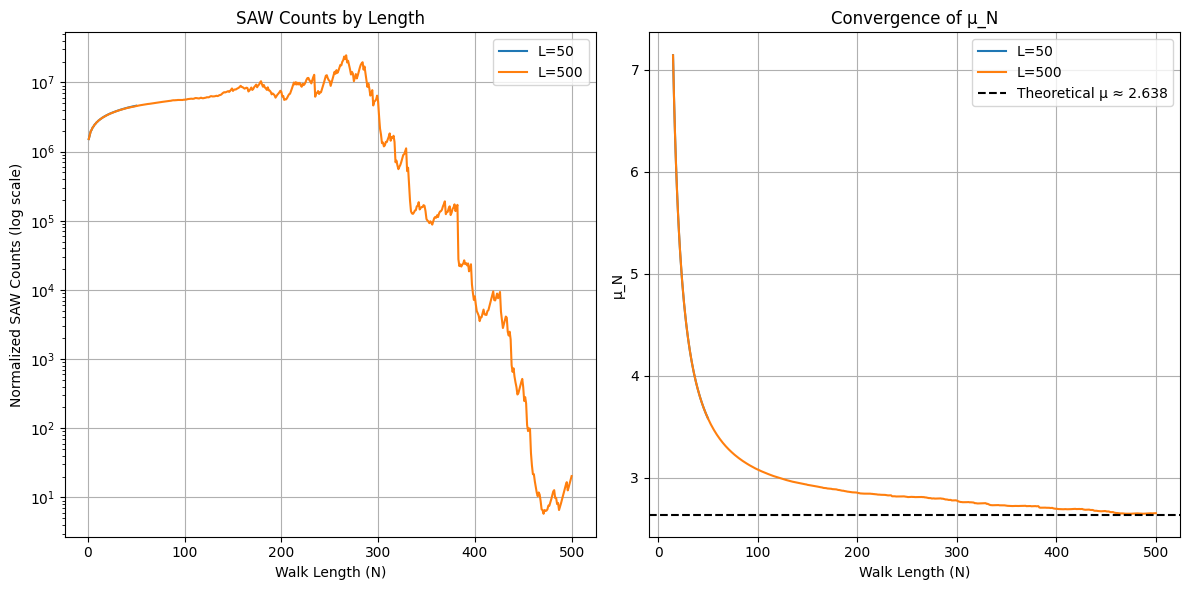

In [3]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, num_walks=10000):
        """Initialize PERM simulator."""
        self.max_length = max_length
        self.num_walks = num_walks
        self.results = np.zeros(max_length + 1, dtype=np.float64)
        self.global_walks = cuda.device_array((num_walks, max_length, 2), dtype=np.int32)

    def run(self):
        """Run GPU simulation."""
        threads = 256
        blocks = (self.num_walks + threads - 1) // threads
        random_states = np.random.randint(1, 2**31, size=self.num_walks, dtype=np.uint32)
        d_results = cuda.to_device(self.results)
        d_random_states = cuda.to_device(random_states)

        perm_gpu_kernel[blocks, threads](
            self.max_length,
            self.num_walks,
            d_results,
            d_random_states,
            self.global_walks
        )

        self.results = d_results.copy_to_host()
        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 50, "num_walks": 100000, "label": "L=50"},
        {"max_length": 500, "num_walks": 1000000, "label": "L=500"},
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], num_walks=case["num_walks"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.6f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        plt.plot(np.arange(min(15, max_length // 2), max_length + 1), mu_N, label=label)
    plt.axhline(y=2.638, color="k", linestyle="--", label="Theoretical μ ≈ 2.638")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Post-simulation Analysis
When L is large, the chance of successfully sampling a SAW is very low, so it's necessary to increase the n_sample. That's why the graph of Normalised SAW counts suddenly drops when L is around 250 and increasing oscillation is observed.

### Solution: batch computing
we run several batches to ensure the sample size is enough for large L.


=== Test Case: L=100 ===


Processing L=100: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


Results: [5.74677786e+08 6.53538044e+08 7.43219913e+08 7.82596532e+08
 8.42520642e+08 8.77181043e+08 9.25948936e+08 9.56054093e+08
 9.96565307e+08 1.02406838e+09 1.05887411e+09 1.08427399e+09
 1.11501719e+09 1.13853748e+09 1.16626862e+09 1.18823936e+09
 1.21362308e+09 1.23427417e+09 1.25777402e+09 1.27715407e+09
 1.29907853e+09 1.31750989e+09 1.33809966e+09 1.35559912e+09
 1.37502985e+09 1.39177714e+09 1.41028764e+09 1.42636203e+09
 1.44399016e+09 1.45944883e+09 1.47627247e+09 1.49110517e+09
 1.50720806e+09 1.52152103e+09 1.53706073e+09 1.55092004e+09
 1.56566550e+09 1.57898606e+09 1.59328589e+09 1.60625187e+09
 1.62012856e+09 1.63289219e+09 1.64660121e+09 1.65909201e+09
 1.67210596e+09 1.68392838e+09 1.69669146e+09 1.70833428e+09
 1.72079283e+09 1.73224757e+09 1.74431066e+09 1.75540713e+09
 1.76722174e+09 1.77800236e+09 1.78967564e+09 1.80057152e+09
 1.81212514e+09 1.82276290e+09 1.83363675e+09 1.84368289e+09
 1.85464527e+09 1.86446668e+09 1.87533368e+09 1.88529948e+09
 1.89535366e+09

Processing L=500: 100%|██████████| 500/500 [39:01<00:00,  4.68s/it]


Results: [1.98905722e+11 2.24272690e+11 2.52996215e+11 2.66163530e+11
 2.86990683e+11 2.98816882e+11 3.16063971e+11 3.20557651e+11
 3.33632636e+11 3.42786869e+11 3.54097371e+11 3.62507064e+11
 3.72061598e+11 3.79067770e+11 3.87676862e+11 3.94476067e+11
 4.02662517e+11 4.09759389e+11 4.17168952e+11 4.23924939e+11
 4.31602244e+11 4.37868702e+11 4.45032071e+11 4.50082071e+11
 4.56373297e+11 4.61135903e+11 4.67396072e+11 4.72844473e+11
 4.78757660e+11 4.84104248e+11 4.89950439e+11 4.95267308e+11
 4.99695815e+11 5.04788650e+11 5.09137470e+11 5.14003077e+11
 5.18283661e+11 5.22283110e+11 5.27255181e+11 5.31795915e+11
 5.36518819e+11 5.40876761e+11 5.44738895e+11 5.49008402e+11
 5.53645955e+11 5.56921947e+11 5.60004198e+11 5.63400529e+11
 5.67292123e+11 5.71040479e+11 5.74914426e+11 5.78570297e+11
 5.82436722e+11 5.85897690e+11 5.89653117e+11 5.93131419e+11
 5.96835479e+11 6.00233524e+11 6.03731173e+11 6.07061959e+11
 6.10616848e+11 6.13881693e+11 6.17317491e+11 6.20516850e+11
 6.23847034e+11

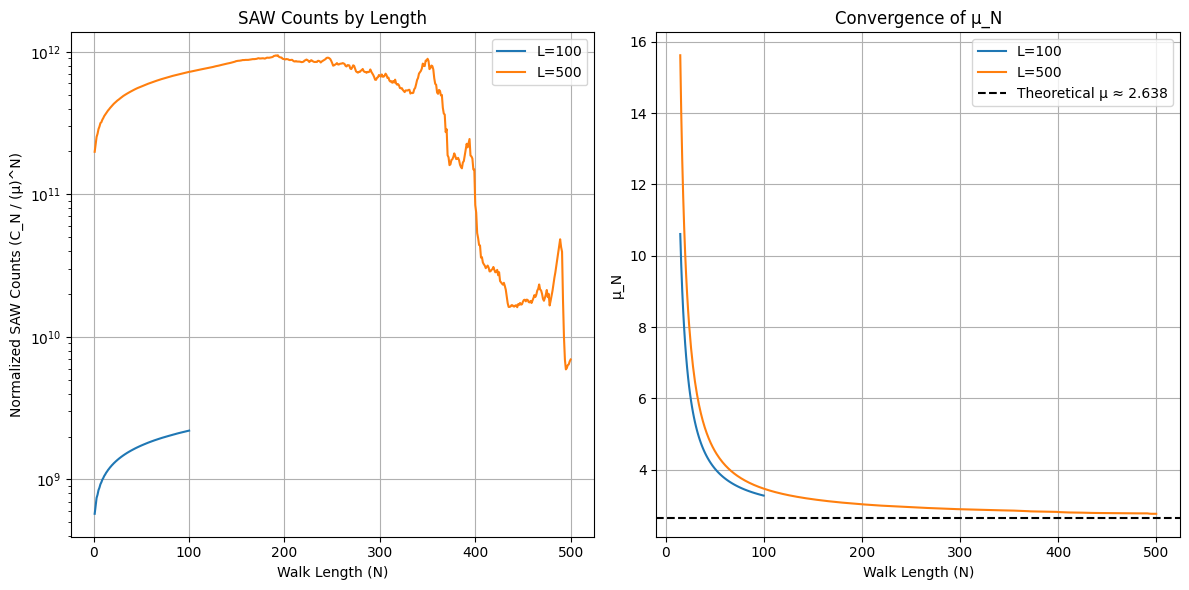

In [2]:
import numpy as np
from numba import cuda, int32, float64
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# ================== Configuration Parameters ==================
USE_LOCAL_MEM = True
LOCAL_MEM_MAX_LENGTH = 128
MU_ESTIMATE = 2.638  # Initial estimate for normalization

# ================== Collision Detection ==================
@cuda.jit(device=True)
def collision_check(walk: int32[:,:], length: int32, new_pos: int32[:], grid_size: int32) -> int32:
    """Check if new_pos collides with existing walk points."""
    for i in range(max(0, length-100), length):
        if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
            return 1
    if grid_size > 0:
        grid_x = new_pos[0] // grid_size
        grid_y = new_pos[1] // grid_size
        for i in range(length):
            dx = abs(walk[i,0] - new_pos[0])
            dy = abs(walk[i,1] - new_pos[1])
            if dx < grid_size and dy < grid_size:
                if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                    return 1
    else:
        for i in range(length):
            if walk[i,0] == new_pos[0] and walk[i,1] == new_pos[1]:
                return 1
    return 0

# ================== GPU Kernel ==================
@cuda.jit
def perm_gpu_kernel(max_length, max_walks, results, random_states, global_walks):
    wid = cuda.grid(1)
    if wid >= max_walks:
        return

    if max_length <= LOCAL_MEM_MAX_LENGTH and USE_LOCAL_MEM:
        walk = cuda.local.array(shape=(LOCAL_MEM_MAX_LENGTH, 2), dtype=int32)
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0
    else:
        walk = global_walks[wid]
        walk_length = 1
        walk[0,0] = 0
        walk[0,1] = 0

    directions = cuda.local.array((4, 2), dtype=int32)
    directions[0,0], directions[0,1] = 1, 0
    directions[1,0], directions[1,1] = -1, 0
    directions[2,0], directions[2,1] = 0, 1
    directions[3,0], directions[3,1] = 0, -1

    rnd_state = random_states[wid]
    weight = 1.0
    current_length = 0
    new_pos = cuda.local.array(2, dtype=int32)

    while current_length < max_length:
        valid_count = 0
        valid_moves = cuda.local.array(4, dtype=int32)

        for d in range(4):
            new_pos[0] = walk[walk_length-1,0] + directions[d,0]
            new_pos[1] = walk[walk_length-1,1] + directions[d,1]
            if not collision_check(walk, walk_length, new_pos, 10):
                valid_moves[valid_count] = d
                valid_count += 1

        if valid_count == 0:
            break

        rnd_state = (rnd_state * 1664525 + 1013904223) & 0xFFFFFFFF
        choice = int32((rnd_state / 4294967296.0) * valid_count)

        d = valid_moves[choice]
        walk[walk_length,0] = walk[walk_length-1,0] + directions[d,0]
        walk[walk_length,1] = walk[walk_length-1,1] + directions[d,1]
        walk_length += 1
        weight *= (valid_count / MU_ESTIMATE)  # Normalize per step
        current_length += 1

        if weight < 1e-200:  # Relaxed underflow threshold
            break

        cuda.atomic.add(results, current_length, weight)

# ================== Main Control Class ==================
class AdaptivePERM:
    def __init__(self, max_length=50, batch_size=100000):
        """Initialize PERM simulator with batch processing."""
        self.max_length = max_length
        self.batch_size = batch_size
        # num_batches dynamically changes with max_length to ensure sufficient sampling
        self.num_batches = max_length  
        self.results = np.zeros(max_length + 1, dtype=np.float64)

    def run(self):
        """Run GPU simulation in batches."""
        threads = 256
        blocks = (self.batch_size + threads - 1) // threads

        for batch in tqdm(range(self.num_batches), desc=f"Processing L={self.max_length}"):
            global_walks = cuda.device_array((self.batch_size, self.max_length, 2), dtype=np.int32)
            random_states = np.random.randint(1, 2**31, size=self.batch_size, dtype=np.uint32)
            d_random_states = cuda.to_device(random_states)
            d_results = cuda.device_array(self.max_length + 1, dtype=np.float64)

            perm_gpu_kernel[blocks, threads](
                self.max_length,
                self.batch_size,
                d_results,
                d_random_states,
                global_walks
            )

            batch_results = d_results.copy_to_host()
            self.results += batch_results

            del global_walks, d_random_states, d_results

        print(f"Results: {self.results[1:self.max_length + 1]}")
        return self.results[1:self.max_length + 1]

    def estimate_constants(self, fit_start=15):
        """Estimate mu and gamma using curve_fit."""
        lengths = np.arange(fit_start, self.max_length + 1)
        if len(lengths) < 3:
            print(f"Warning: Not enough data points ({len(lengths)}), returning NaN.")
            return np.nan, np.nan, []

        c_N_adjusted = np.maximum(self.results[fit_start:self.max_length + 1], 1e-300)
        response = np.log(c_N_adjusted) + np.log(MU_ESTIMATE) * lengths

        def fitting_func(N, log_mu, A, gamma):
            return N * log_mu + (gamma - 1) * np.log(N) + A

        p0 = [np.log(MU_ESTIMATE), 1.0, 1.344]  # Initial guess: log(mu), A, gamma
        bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Ensure mu, gamma > 0
        try:
            popt, _ = curve_fit(fitting_func, lengths, response, p0=p0, bounds=bounds)
            log_mu_est, A_est, gamma_est = popt
            mu_est = np.exp(log_mu_est)
        except RuntimeError as e:
            print(f"Curve fitting failed: {e}, returning NaN values.")
            return np.nan, np.nan, []

        mu_N = [(c * MU_ESTIMATE ** N) ** (1 / N) for c, N in zip(c_N_adjusted, lengths)]
        return mu_est, gamma_est, mu_N

# ================== Test Cases ==================
if __name__ == "__main__":
    test_cases = [
        {"max_length": 100, "batch_size": 1000000, "label": "L=100"},
        {"max_length": 500, "batch_size": 2000000, "label": "L=500"}
    ]

    results_all = []
    mu_N_all = []

    for case in test_cases:
        print(f"\n=== Test Case: {case['label']} ===")
        sim = AdaptivePERM(max_length=case["max_length"], batch_size=case["batch_size"])
        start = time.time()
        results = sim.run()
        mu, gamma, mu_N = sim.estimate_constants(fit_start=min(15, case["max_length"] // 2))
        gpu_time = time.time() - start
        print(f"μ = {mu:.16f}, γ = {gamma:.6f}")
        print(f"GPU Time: {gpu_time:.3f}s")
        results_all.append((results, case["label"]))
        mu_N_all.append((mu_N, case["label"], case["max_length"]))

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot C_N
    plt.subplot(1, 2, 1)
    for results, label in results_all:
        plt.plot(np.arange(1, len(results) + 1), results, label=label)
    plt.xlabel("Walk Length (N)")
    plt.ylabel("Normalized SAW Counts (C_N / (μ)^N)")
    plt.yscale("log")
    plt.title("SAW Counts by Length")
    plt.legend()
    plt.grid(True)

    # Plot mu_N
    plt.subplot(1, 2, 2)
    for mu_N, label, max_length in mu_N_all:
        fit_start = min(15, max_length // 2)
        plt.plot(np.arange(fit_start, max_length + 1), mu_N, label=label)
    plt.axhline(y=MU_ESTIMATE, color="k", linestyle="--", label=f"Theoretical μ ≈ {MU_ESTIMATE}")
    plt.xlabel("Walk Length (N)")
    plt.ylabel("μ_N")
    plt.title("Convergence of μ_N")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#### Post-simulation Analysis
The method works as the $L_0$ value where oscillation increases occurs is larger than previous runs.

However, the estimation is still far from satisfying when L is large. We can increase the samples for larger L, but this takes much longer computation time (so here we skip this part). Therefore, GPU Version of PERM will still lose its advantage when L is large and pivot algorithms will be a better choice.
